In [4]:
import numpy as np
from copy import deepcopy
import scipy.sparse as sp
from scipy.stats import poisson
from scipy import signal
from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndi
from skimage.filters import gabor_kernel

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from multiprocessing import Process, Manager

In [5]:
import os
import sys
sys.path.append(os.path.abspath("../"))
for p in sys.path:
    print(p)
# from caller.StripeCaller import stripe_caller_all as stripe_caller
from Quagga import stripe_caller, load_HiC

def strata2horizontal(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding horizontal stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th row, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the row),
    which is row[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding horizontal stripes

    """
    hmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        hmat[:len(strata[i]), i] = strata[i]
    return hmat

def strata2vertical(strata):
    """
    From strata loaded from load_HiC(), construct the matrix for finding vertical stripes.
    Assuming the full contact map is N * N and the first p strata are loaded in memory,
    for the k-th column, we pick up the p-pixel slice start from the matrix diagonal (i.e., the k-th element of the column),
    which is column[k: k + p].
    The result is a N * p matrix.

    Parameters
    ----------
    strata: list of np.array (1D)
        Loaded Hi-C strata

    Returns
    ----------
    hmat: np.array (2D)
        The N * p matrix for finding vertical stripes

    """
    vmat = np.zeros((len(strata[0]), len(strata)))
    for i in range(len(strata)):
        vmat[i:, i] = strata[i]
    return vmat

def subsetNpMatrix(matrix, row_bounds, column_bounds):
    """
    Obtain the correct slice of a matrix considering x and y boundaries

    Parameters
    ----------
    matrix: np.array
        The original matrix

    row_bounds: tuple
        The upper and lower bounds for row indices

    column_bounds: tuple
        The upper and lower bounds for column indices

    Returns
    ----------
    subset: np.array
        The sub-matrix after slicing
    """
    rows = np.array([x for x in range(row_bounds[0], row_bounds[1]) if 0 <= int(x) < matrix.shape[0]])
    cols = np.array([y for y in range(column_bounds[0], column_bounds[1]) if 0 <= int(y) < matrix.shape[1]])
    if len(rows)==0 or len(cols)==0:
        return np.empty(0)
    subset = (matrix.ravel()[(cols + (rows * matrix.shape[1]).reshape((-1, 1))).ravel()]).reshape(rows.size, cols.size)
    return subset

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def find_max_slice(arr):
    """
    Given the enrichment score of each pixel along the candidate stripe,
    find the slice with the largest sum as a called stripe.

    Parameters
    ----------
    arr: np.array (1D)
        Enrichment score

    Returns
    ----------
    head: int
        The start location of the slice

    tail: int
        The end location of the slice

    _max: float
        The sum of scores of the slice

    """
    _max, head, tail = 0, 0, 0
    _max_ending, h, t = 0, 0, 0
    i = 0
    while i < len(arr):
        _max_ending = _max_ending + arr[i]
        if _max_ending < 0:
            h, t = i + 1, i + 1
            _max_ending = 0
        else:
            t = i + 1
        if _max_ending > _max:
            head, tail, _max = h, t, _max_ending
        i += 1
    return head, tail, _max

/Users/fanfeng/Documents/Quagga/StripeCaller/example
/Users/fanfeng/opt/anaconda3/lib/python39.zip
/Users/fanfeng/opt/anaconda3/lib/python3.9
/Users/fanfeng/opt/anaconda3/lib/python3.9/lib-dynload

/Users/fanfeng/opt/anaconda3/lib/python3.9/site-packages
/Users/fanfeng/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/fanfeng/Documents/Quagga/StripeCaller
..
..
/Users/fanfeng/Documents/Quagga/StripeCaller


In [6]:
def visualize2(start, end, strata1, resolution=25000):
    st, ed = start // resolution, end // resolution
    
    length = ed - st
    mat1 = np.zeros((length, length))
    
    # mat1: Upper tri
    for i, strata in enumerate(strata1):
        for j in range(length - i):
            mat1[j, j + i] = strata[st + j]
            if j != 0:
                mat1[j + i, j] = strata[st + j]
    # sub_mat = np.log(mat1 + 1)
    sub_mat = mat1
    
    st_Mb, ed_Mb = start // 500000 if start % 500000 == 0 else start // 500000 + 1, end // 500000
    tick_labels = np.arange(st_Mb, ed_Mb + 1)
    ticks = (tick_labels * 500000 - start) // resolution
    tick_labels = [str(elm // 2) + ' Mb' if elm % 2 == 0 else str(elm // 2) + '.5 Mb' for elm in tick_labels]
    # print(tick_labels, ticks)
    
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(sub_mat, square=True, cmap='Reds', vmin=0, vmax=np.quantile(sub_mat, 0.98), yticklabels=tick_labels, xticklabels=tick_labels)
    ax.set_xticks(ticks, tick_labels)
    ax.set_yticks(ticks, tick_labels)
    plt.show()


from AVL_tree import AVLTree


def enrichment_score2(mat, idx, line_width, norm_factors, distance_range=(20, 40), window_size=10,
                      stats_test_log=({}, {})):
    """
    Calculate the enrichment score of a stripe given its location, width and the contact matrix

    Parameters:
    ----------
    mat: np.array (2D)
        Contact matrix generated with strata2horizontal() or strata2vertical()

    idx: int
        The location (index) of the candidate stripe

    line_width: int
        Stripe width (# of bins)

    norm_factors: np.array (1D)
        The vector of normalization factors of the contact map.

    distance_range: tuple
        The distance range (# of bins) for the diagonal for calculating the scores

    window_size: int
        Window size (# of bins)

    stats_test_log: tuple of dict
        Previous log for accelerating statistical tests


    Returns
    ----------
    new_mat: np.array (1D)
        The enrichment score of each pixel along the candidate stripe

    """
    _calculated_values, _poisson_stats = stats_test_log

    half = int(line_width // 2)
    x1, x2 = idx - half, idx - half + line_width
    if x1 == x2:
        x2 += 1

    new_mat = np.zeros((distance_range[1] - distance_range[0],))
    _exps, _obss = np.zeros((distance_range[1] - distance_range[0],)), np.zeros((distance_range[1] - distance_range[0],))
    for j in range(distance_range[0], distance_range[1]):
        y = j - distance_range[0]
        _min_temp = subsetNpMatrix(mat, (x1, x2), (j - window_size - half, j + window_size + half + 1))
        line_min = np.median([_min_temp])
        # print(_min_temp, line_min)
        _inner_neighbor = subsetNpMatrix(mat, (idx - half - window_size, x1),
                                         (j - window_size - half, j + window_size + half + 1))
        _outer_neighbor = subsetNpMatrix(mat, (x2 + 1, idx + half + window_size + 1),
                                         (j - window_size - half, j + window_size + half + 1))

        if _outer_neighbor.size == 0 or _inner_neighbor.size == 0:
            continue
            
        neighbor_mean = max(np.mean(_inner_neighbor), np.mean(_outer_neighbor))

        # There should be a lower bound for the expected value,
        # otherwise situations like (exp=0.01 and obs=0.02) would also be significant
        # Currently we can set this to 0 until KR norm factors can be loaded
        lower_b = 1 / norm_factors[idx]  # This should be (1 / KR_norm_factors) if we refer to JuiceTools HICCUPS
        _exp = max(neighbor_mean, lower_b)
        _obs = int(line_min)  # the same as floor function when line_min > 0
        _exps[y] = _exp
        _obss[y] = _obs

        # _calculated_values: store all calculated exp-obs pairs in dictionary, in which keys are obs since
        #     they are always integers. Each _calculated_values[obs] is a binary tree for quick searching,
        #     and each tree leaf is a exp value corresponding to the obs value. Since exp values are float,
        #     there is also an integer index attached for searching the exp-obs in dictionary _poisson_stats
        #     (float cannot be dict keys).
        # _poisson_stats: record all calculated result in a dict. It should be
        #     _poisson_stats[(_exp, _obs)] = -log10(p). But _exp is a float and cannot be a dict key, we give
        #     each _exp a unique index and use the index.
        # stats_log: record all p value calculation. Just for benchmarking. Delete this when publishing.

        # global _calculated_values, _poisson_stats  # , stats_log
        tolerance = 0.02

        # check if obs is a value calculated before
        if _obs in _calculated_values:
            # Find the nearest _exp values which were calculated before
            # One larger, one smaller
            (_upper, _lower) = _calculated_values[_obs].search(_exp)
            # If _upper is close enough to _exp, directly use the p value from (_upper-_obs) pair
            if _upper is not None and (_upper.key - _exp) < tolerance * _exp:
                _exp = _upper.key
                _exp_idx = _upper.val  # The integer index for _upper (float cannot be dict keys!)
                mlog_p_val = _poisson_stats[(_exp_idx, _obs)]
            else:
                # Else, calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
                _exp_idx = _calculated_values[_obs].insert(_exp)  # insert to the binary tree and return an index
                Poiss = poisson(_exp)
                p_val = 1 - Poiss.cdf(_obs)
                if 0 < p_val:
                    mlog_p_val = - np.log10(p_val)
                else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                    mlog_p_val = -1
                _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
                # stats_log.append([_exp, _obs, mlog_p_val])
        else:  # If _obs is not used before, generate a new binary tree _calculated_values[_obs]
            _calculated_values[_obs] = AVLTree()
            _exp_idx = _calculated_values[_obs].insert(_exp)
            # calculate p value for _obs-_exp pair and store them in _calculated_values and _poisson_stats
            Poiss = poisson(_exp)
            p_val = 1 - Poiss.cdf(_obs)
            if 0 < p_val:
                mlog_p_val = - np.log10(p_val)
            else:  # Some p values are too small, -log(0) will return an error, so we use -1 to temporarily replace
                mlog_p_val = -1
            _poisson_stats[(_exp_idx, _obs)] = mlog_p_val
            # stats_log.append([_exp, _obs, mlog_p_val])

        # Store enrichment score in new_mat
        new_mat[y] = mlog_p_val
    new_mat[new_mat < 0] = np.max(new_mat)  # Replace all "-1"s with the largest -log(p)

    return new_mat, _obss, _exps

## All Parameters

In [7]:
file = '/Users/fanfeng/Documents/Quagga/4943.hic'
ch = 'chr16'
rg = 'hg19'
norm = 'balanced'
max_range = 3000000
resolution = 10000
min_length = 50000
min_distance = 500000
window_size = 2
sigma = 2
rel_height = 0.1
thr = 0.15
nstrata_blank = 2
# I ignored "N_cores"

## 1 Load Hi-C and visualize the example region

In [8]:
strata, norm_factors = load_HiC.load_HiC(
    file=file, 
    ref_genome=rg, format="hic",
    chromosome=ch, resolution=resolution, norm=norm,
    max_distance=max_range + min_length
)

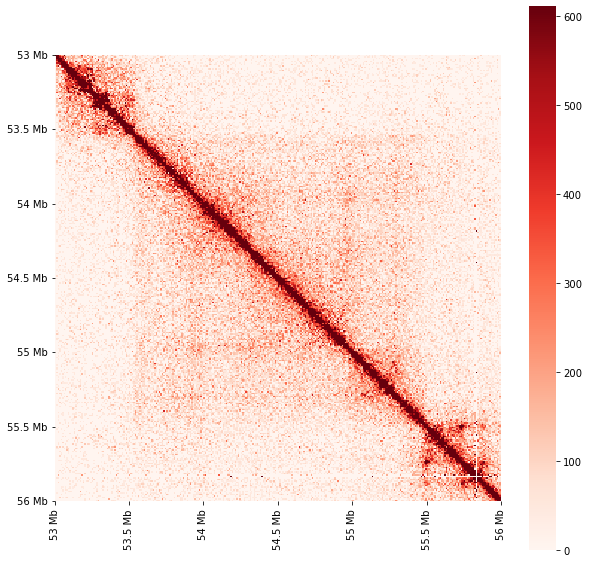

In [9]:
# Visualize the region
region_start, region_end = 53000000, 56000000

visualize2(region_start, region_end, strata, resolution=resolution)

In [10]:
# Check whether the norm factors are reasonable (around 1)
norm_factor_subset = norm_factors[region_start // resolution: region_end // resolution]
print(norm_factor_subset.shape)
print(norm_factor_subset[:30])

(300,)
[1.04954719 1.08401525 1.13057182 0.94686784 1.00645105 1.14986794
 1.00211043 1.08315579 1.17953291 1.16996142 0.83155356 0.99644993
 1.14044351 0.92526231 1.01468486 1.09570765 0.97163778 0.86559124
 0.87729708 1.06564316 1.03367947 0.82471951 0.68146697 0.74826502
 0.76676749 0.79894824 0.97696813 0.80371021 1.02068707 0.73594907]


In [11]:
# Convert the strata to "horizontal" matrix
hmat = strata2horizontal(strata)
print(hmat.shape)
st, ed = region_start // resolution, region_end // resolution
sub_hmat = hmat[st:ed, :]
print(sub_hmat.shape)

(9036, 305)
(300, 305)


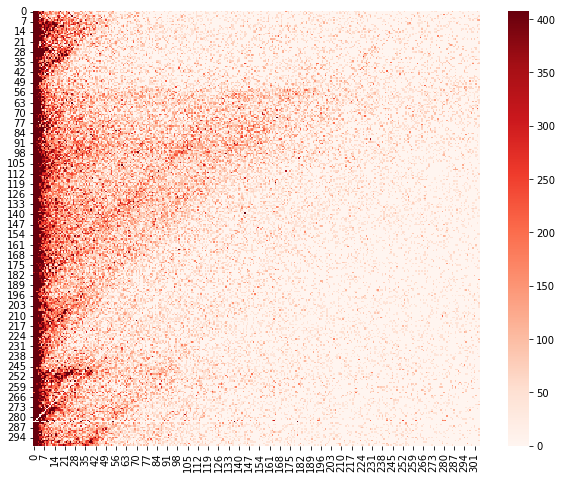

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(sub_hmat, cmap='Reds', vmin=0, vmax=np.quantile(sub_hmat, 0.98))
plt.show()

## 2 Find candidate stripes

In [13]:
def get_stripe_and_widths_new(mat, nstrata_gap=400, nstrata_blank=10,
                              sigma=12., rel_height=0.3, max_width=5,
                              gabor_freq=0.1, gabor_theta=0,
                              st=53000000//10000, ed=56000000//10000):
    """
    From the sparse contact map, generate candidate vertical / horizontal stripes.

    Parameters
    ----------
    mat: np.array
        Contact matrix from "strata2horizontal()" or "strata2vertical()"

    nstrata_gap: int
        Max distance from the diagonal to calculate candidate peaks

    nstrata_blank: int
        Number of strata near the diagonal to blank out to calculate candidate peaks

    sigma: float
        Gaussian filter std

    rel_height: float
        Relative peak height for width calling

    Returns
    ----------
    peaks: dict
        Peak locations and peak widths

    """
    # print(nstrata_gap)
    # print(mat.shape, nstrata_blank, nstrata_gap)
    # print(np.sum(mat))
    orig_mat = deepcopy(mat[st:ed, :nstrata_gap].T)
    theta = gabor_theta*np.pi/2
    kernel = gabor_kernel(gabor_freq, theta=theta)
    mat = power(mat, kernel)
    mat_sum = np.sum(mat[:, nstrata_blank:nstrata_gap], axis=1)
    # np.save('K562.npy', mat_sum)
    s_filtered = gaussian_filter1d(mat_sum, sigma=sigma)
    s_max = signal.argrelmax(s_filtered)[0]
    # np.savetxt('s_max.txt', s_max)
    s_widths = signal.peak_widths(s_filtered, peaks=s_max, rel_height=rel_height)[0]
    s_widths[s_widths > max_width] = max_width
    
    peaks = {i: j for (i, j) in zip(s_max, s_widths)}
    
    plt.figure(figsize=(9, 15))
    plt.subplot(311)
    sns.heatmap(orig_mat, cmap='Reds', vmin=0, vmax=np.quantile(orig_mat, 0.98), cbar=False)
    plt.subplot(312)
    temp_mat = deepcopy(mat[st:ed, :nstrata_gap])
    temp_mat[:, :nstrata_blank] = 0
    temp_mat = temp_mat.T
    sns.heatmap(temp_mat, cmap='Reds', vmin=0, vmax=np.quantile(temp_mat, 0.98), cbar=False)
    plt.subplot(313)
    plt.plot(np.arange(ed - st), mat_sum[st:ed])
    plt.plot(np.arange(ed - st), s_filtered[st:ed])
    
    width = np.zeros((ed - st,))
    for k in peaks:
        if k >= ed or k < st:
            continue
        plt.axvline(k - st, color='red')
        w = int(round(peaks[k]))
        peak_st, peak_ed = max(0, k - st - w // 2), min(ed - st, k - st + w // 2 + 1)
        # print(peak_st, peak_ed, k, st, signals[0][k - st])
        width[peak_st: peak_ed] = mat_sum[k]
    
    plt.fill_between(np.arange(ed - st), 0, width, alpha=0.3, color='gray')
    plt.xlim([0, ed - st])
    plt.show()
    plt.close()
    
    return peaks

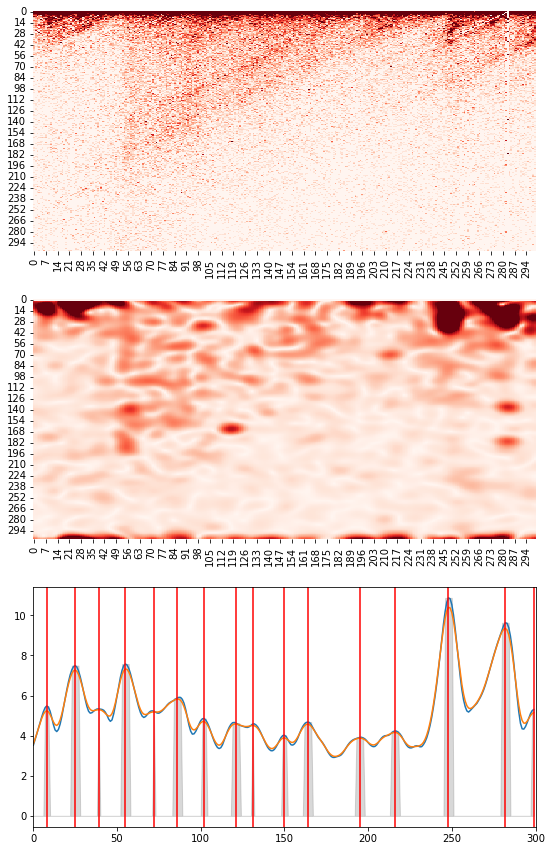

In [14]:
h_Peaks = get_stripe_and_widths_new(
    hmat, nstrata_gap=(max_range + min_length) // resolution, nstrata_blank=nstrata_blank,
    sigma=sigma, rel_height=rel_height, max_width=5,
    gabor_freq=0.1, gabor_theta=1,
    st=region_start // resolution, ed=region_end // resolution
)

In [15]:
def get_stripe_and_widths_new2(mat, nstrata_gap=400, nstrata_blank=10,
                              sigma=12., rel_height=0.3, max_width=5,
                              gabor_freq=0.1, gabor_theta=0,
                              st=53000000//10000, ed=56000000//10000):
    """
    From the sparse contact map, generate candidate vertical / horizontal stripes.

    Parameters
    ----------
    mat: np.array
        Contact matrix from "strata2horizontal()" or "strata2vertical()"

    nstrata_gap: int
        Max distance from the diagonal to calculate candidate peaks

    nstrata_blank: int
        Number of strata near the diagonal to blank out to calculate candidate peaks

    sigma: float
        Gaussian filter std

    rel_height: float
        Relative peak height for width calling

    Returns
    ----------
    peaks: dict
        Peak locations and peak widths

    """
    # print(nstrata_gap)
    # print(mat.shape, nstrata_blank, nstrata_gap)
    # print(np.sum(mat))
    orig_mat = deepcopy(mat[st:ed, :nstrata_gap].T)
    theta = gabor_theta*np.pi/2
    kernel = gabor_kernel(gabor_freq, theta=theta)
    mat = power(mat, kernel)
    mat_sum = np.sum(mat[:, nstrata_blank:nstrata_gap - 6], axis=1)
    # np.save('K562.npy', mat_sum)
    s_filtered = gaussian_filter1d(mat_sum, sigma=sigma)
    s_max = signal.argrelmax(s_filtered)[0]
    # np.savetxt('s_max.txt', s_max)
    s_widths = signal.peak_widths(s_filtered, peaks=s_max, rel_height=rel_height)[0]
    s_widths[s_widths > max_width] = max_width
    
    peaks = {i: j for (i, j) in zip(s_max, s_widths)}
    
    plt.figure(figsize=(9, 15))
    plt.subplot(311)
    sns.heatmap(orig_mat, cmap='Reds', vmin=0, vmax=np.quantile(orig_mat, 0.98), cbar=False)
    plt.subplot(312)
    temp_mat = deepcopy(mat[st:ed, :nstrata_gap - 6])
    temp_mat[:, :nstrata_blank] = 0
    temp_mat = temp_mat.T
    sns.heatmap(temp_mat, cmap='Reds', vmin=0, vmax=np.quantile(temp_mat, 0.98), cbar=False)
    plt.subplot(313)
    plt.plot(np.arange(ed - st), mat_sum[st:ed])
    plt.plot(np.arange(ed - st), s_filtered[st:ed])
    
    width = np.zeros((ed - st,))
    for k in peaks:
        if k >= ed or k < st:
            continue
        plt.axvline(k - st, color='red')
        w = int(round(peaks[k]))
        peak_st, peak_ed = max(0, k - st - w // 2), min(ed - st, k - st + w // 2 + 1)
        # print(peak_st, peak_ed, k, st, signals[0][k - st])
        width[peak_st: peak_ed] = mat_sum[k]
    
    plt.fill_between(np.arange(ed - st), 0, width, alpha=0.3, color='gray')
    plt.xlim([0, ed - st])
    plt.show()
    plt.close()
    
    return peaks

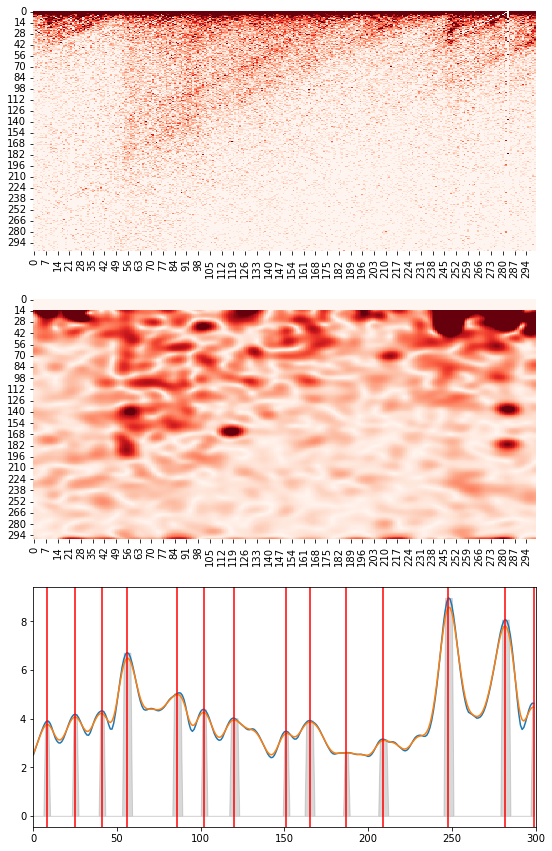

In [18]:
h_Peaks = get_stripe_and_widths_new2(
    hmat, nstrata_gap=(max_range + min_length) // resolution, nstrata_blank=14,
    sigma=sigma, rel_height=rel_height, max_width=5,
    gabor_freq=0.1, gabor_theta=1,
    st=region_start // resolution, ed=region_end // resolution
)

In [19]:
st = region_start // resolution
ed = region_end // resolution
print('Index_on_chr - Index_on_subMat - Width')
for k, v in h_Peaks.items():
    if st <= k < ed:
        print(k, k - st, v)

Index_on_chr - Index_on_subMat - Width
5308 8 2.3849873754543296
5325 25 4.283029056784471
5339 39 1.0387920609909997
5355 55 5.0
5372 72 0.28942037837441603
5386 86 4.3691348537786325
5402 102 2.3353496349291163
5421 121 5.0
5431 131 0.9070241383233224
5450 150 1.8413827165204566
5464 164 4.535482825961481
5495 195 4.021705060618842
5516 216 4.868996497757507
5548 248 5.0
5582 282 5.0
5599 299 2.583864235232795


## 3 Check the statistical test results for some stripes

In [21]:
# hmat must be loaded
def check_stats_result(hmat, pos, width, pval=0.10, window=10):
    sub_mat = hmat[pos - 50: pos + 51, :max_range // resolution]
    enrichment_score, _obs, _exp = enrichment_score2(
        hmat, pos, width, norm_factors,
        distance_range=(0, max_range // resolution), window_size=10,
        stats_test_log=({}, {})
    )
    head, tail, _max = find_max_slice(enrichment_score + np.log10(pval))

    plt.figure(figsize=(9, 9))
    plt.subplot(311)
    sns.heatmap(sub_mat, square=False, cmap='Reds', vmax=np.quantile(sub_mat, 0.98), vmin=0, cbar=False)
    plt.subplot(312)
    plt.plot(np.arange(len(enrichment_score)), _obs, label='Observed')
    plt.plot(np.arange(len(enrichment_score)), _exp, label='Neighbor')
    plt.legend()
    plt.xlim([0, sub_mat.shape[1]])
    plt.subplot(313)
    plt.plot(np.arange(len(enrichment_score)), enrichment_score, label='P value')
    plt.plot(np.arange(head, tail), enrichment_score[head: tail], c='black')
    plt.axhline(-np.log10(pval), c='red', label='Threshold')
    plt.legend()
    plt.xlim([0, sub_mat.shape[1]])
    plt.show()

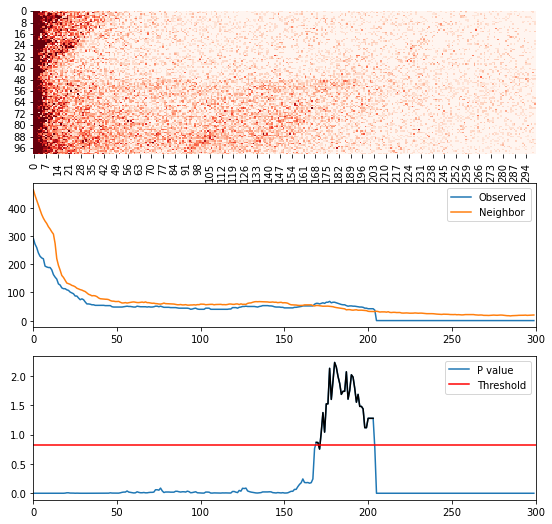

In [23]:
# "5355 55 5.0" This might be a stripe
check_stats_result(hmat, pos=5355, width=5, pval=thr, window=window_size)

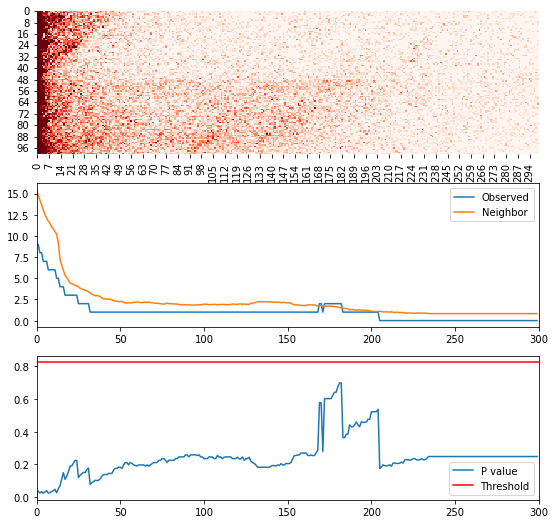

In [31]:
# "5355 55 5.0" This might be a stripe
# If we divide everything by 30
check_stats_result(hmat / 30, pos=5355, width=5, pval=thr, window=window_size)

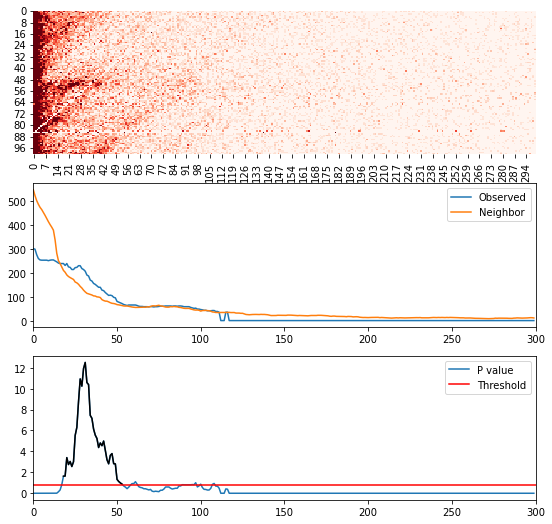

In [24]:
# "5548 248 5.0" This might be a short stripe
check_stats_result(hmat, pos=5548, width=5, pval=thr, window=window_size)

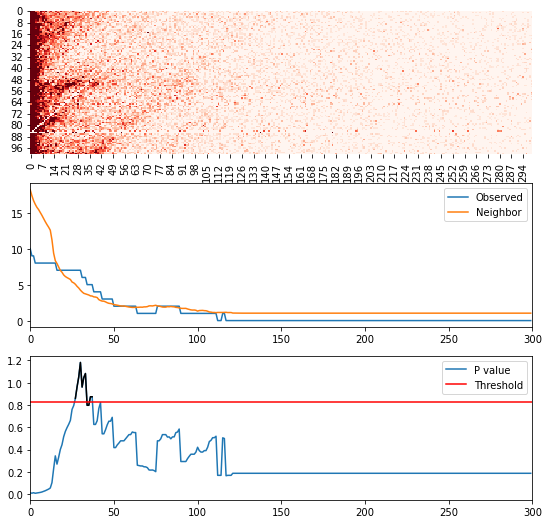

In [32]:
# "5548 248 5.0" This might be a short stripe
# If we divide everything by 30
check_stats_result(hmat / 30, pos=5548, width=5, pval=thr, window=window_size)

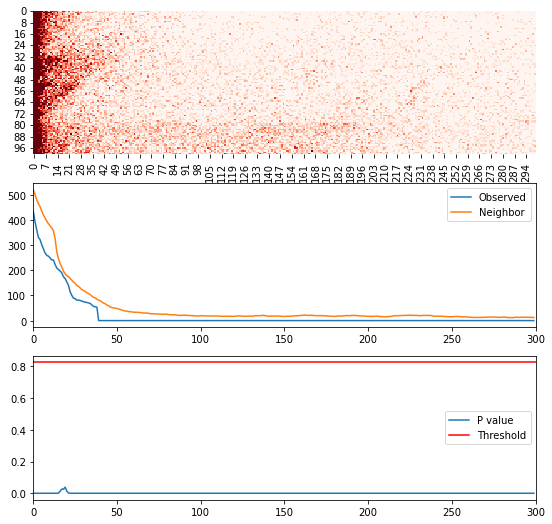

In [27]:
# 5325 25 4.283029056784471 This should not be a stripe
check_stats_result(hmat, pos=5325, width=4, pval=thr, window=window_size)

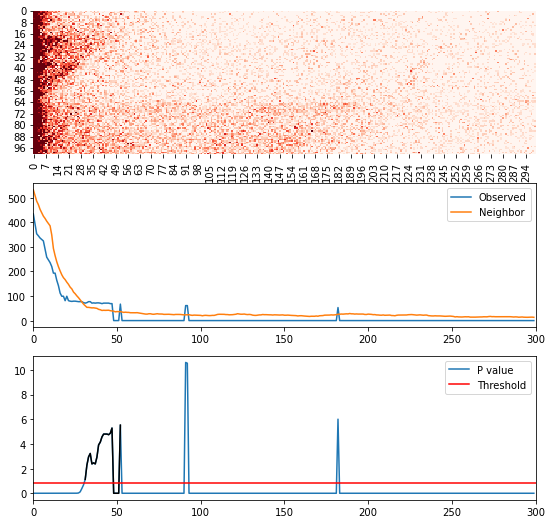

In [25]:
# "5339 39 1.0387920609909997" The false positive!
check_stats_result(hmat, pos=5339, width=1, pval=thr, window=window_size)

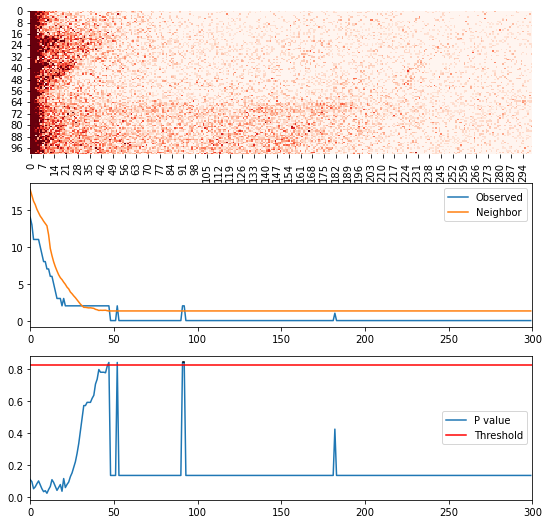

In [28]:
# "5339 39 1.0387920609909997" The false positive!
# If we divide everything by 30
check_stats_result(hmat / 30, pos=5339, width=1, pval=thr, window=window_size)

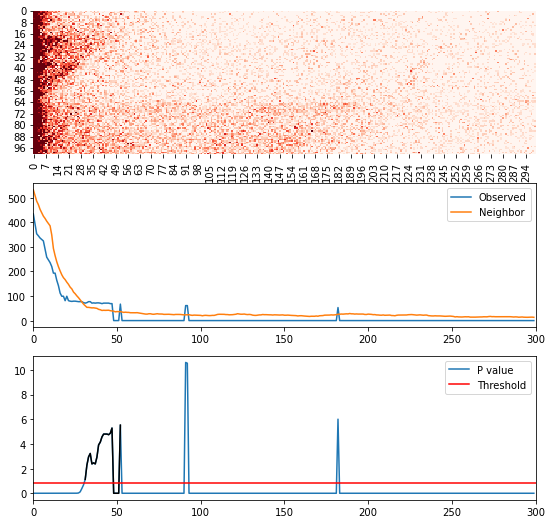

In [26]:
# "5339 39 1.0387920609909997" The false positive!
# If we change the window size
check_stats_result(hmat, pos=5339, width=1, pval=thr, window=5)

## I also checked the vertical stripes

## 1 Get the matrix ready and find candidate stripes

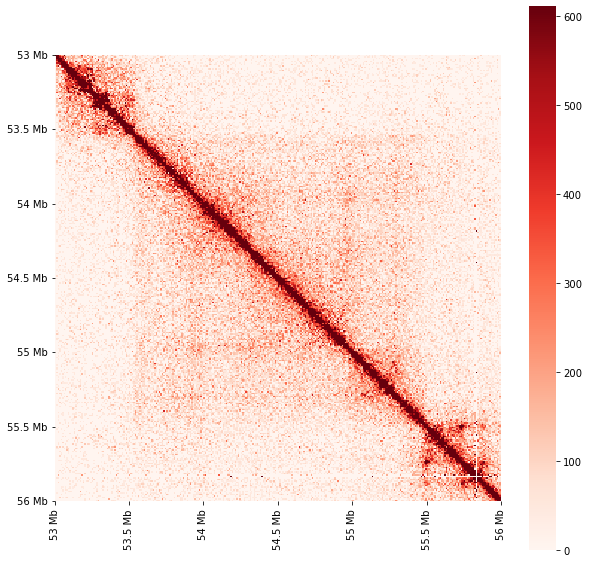

In [33]:
# Visualize the region
region_start, region_end = 53000000, 56000000

visualize2(region_start, region_end, strata, resolution=resolution)

(9036, 305)
(300, 305)


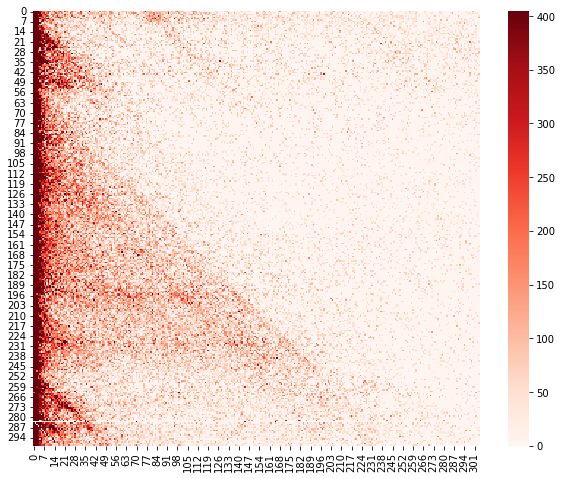

In [34]:
# Convert the strata to "horizontal" matrix
vmat = strata2vertical(strata)
print(vmat.shape)
st, ed = region_start // resolution, region_end // resolution
sub_vmat = vmat[st:ed, :]
print(sub_vmat.shape)

plt.figure(figsize=(10, 8))
sns.heatmap(sub_vmat, cmap='Reds', vmin=0, vmax=np.quantile(sub_vmat, 0.98))
plt.show()

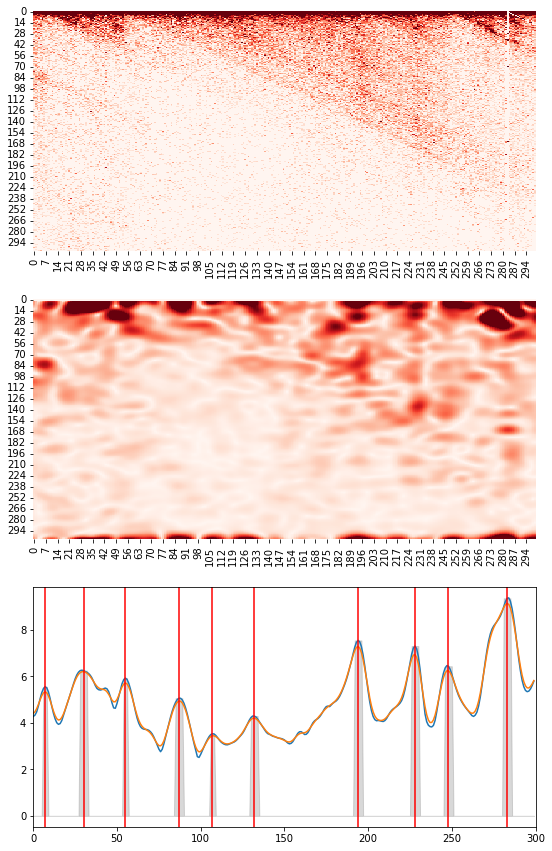

In [41]:
v_Peaks = get_stripe_and_widths_new(
    vmat, nstrata_gap=(max_range + min_length) // resolution, nstrata_blank=nstrata_blank,
    sigma=sigma, rel_height=rel_height, max_width=5,
    gabor_freq=0.1, gabor_theta=1,
    st=region_start // resolution, ed=region_end // resolution
)

In [36]:
st = region_start // resolution
ed = region_end // resolution
print('Index_on_chr - Index_on_subMat - Width')
for k, v in v_Peaks.items():
    if st <= k < ed:
        print(k, k - st, v)

Index_on_chr - Index_on_subMat - Width
5307 7 2.77426590257528
5330 30 5.0
5355 55 2.598409716606511
5387 87 5.0
5407 107 2.956188125736844
5432 132 4.652144039737323
5494 194 4.929819147608214
5528 228 3.9078421082376735
5548 248 4.1003643142275905
5583 283 5.0


## 2 Statistical test for vertical stripes

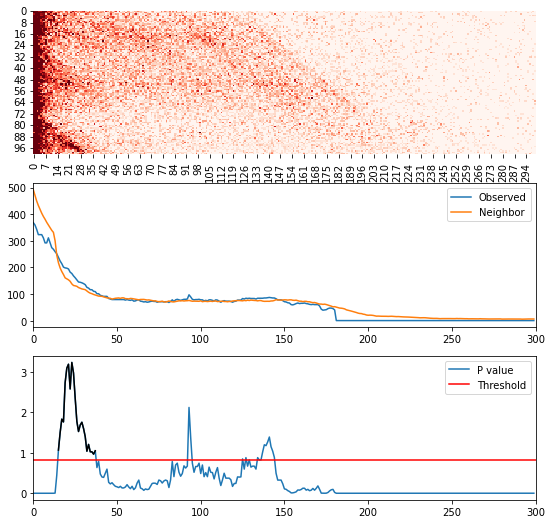

In [42]:
# "5528 228 3.9078421082376735" Might be a stripe
check_stats_result(vmat, pos=5528, width=4, pval=thr, window=window_size)

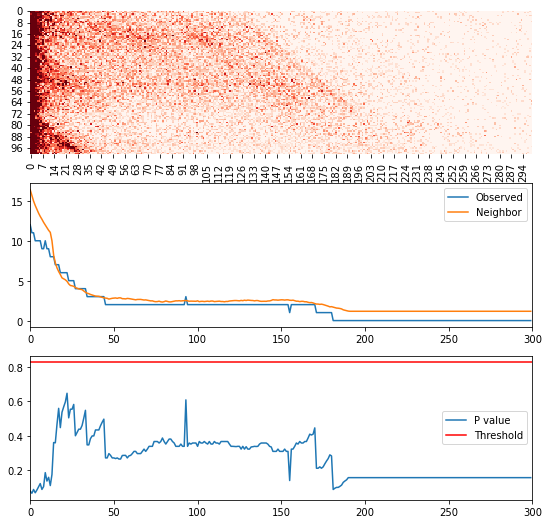

In [43]:
# "5528 228 3.9078421082376735" Might be a stripe
# If we divide everything by 30
check_stats_result(vmat / 30, pos=5528, width=4, pval=thr, window=window_size)

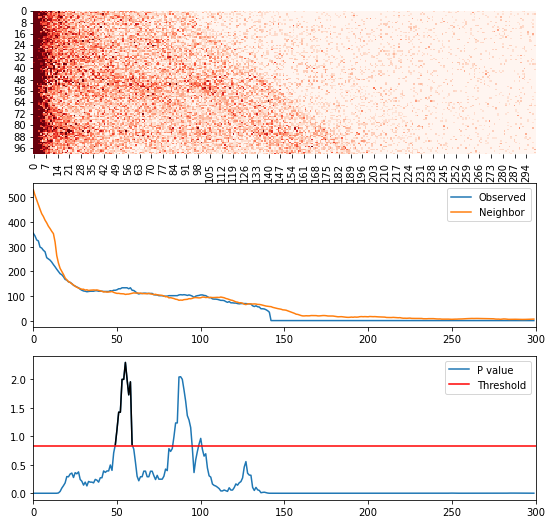

In [44]:
# 5494 194 4.929819147608214 Might be a stripe
check_stats_result(vmat, pos=5494, width=5, pval=thr, window=window_size)

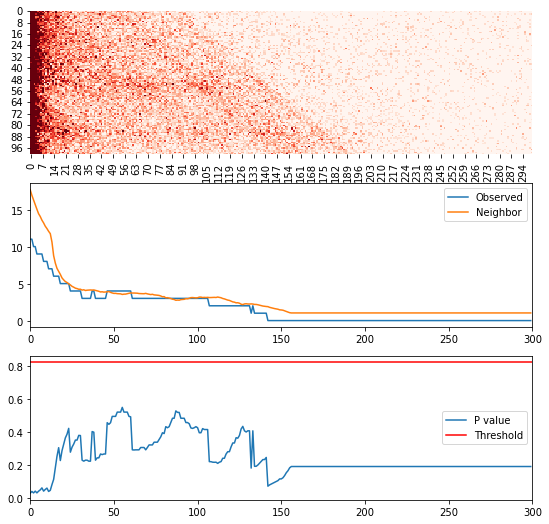

In [47]:
# 5494 194 4.929819147608214 Might be a stripe
# If we divide everything by 30
check_stats_result(vmat / 30, pos=5494, width=5, pval=thr, window=window_size)